In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st

%matplotlib inline

#import the data. (source:Kaggle)
df = pd.read_csv('diamonds.csv')

#drop 'unnamed: 0' column as it is a redundant index column
df = df.drop(['Unnamed: 0'], axis=1)

#how many rows have size values of 0 for each dimension (length, width, height of the diamond)
print('Number of rows with value of 0')
for dim in ['x', 'y', 'z']:
    print(dim, ":", len(df[df[dim] == 0]))

#remove diamonds size values of 0
for dim in ['x', 'y', 'z']:
    df = df[df[dim] != 0]

#optional: combine size measurements to a single feature
#df['size'] = df['x'] * df['y'] * df['z']
#df = df.drop(['x' , 'y', 'z'], axis=1)

#optional: renaming some column names to make them more clear (x = length of the diamond etc.)
df = df.rename(columns={'depth':'depth percentage', 'x':'length', 'y':'width', 'z':'depth'})

#optional: density parameter
#df['density'] = (df['carat'] * 200) / df['size']
#df = df.drop(['size'], axis=1)

#show the first 5 rows of the dataset
df.head()

Number of rows with value of 0
x : 8
y : 7
z : 20


,carat,cut,color,clarity,depth percentage,table,price,length,width,depth
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Shape of dataset (rows/columns)
(53920, 10)

Number of missing values
carat               0
cut                 0
color               0
clarity             0
depth percentage    0
table               0
price               0
length              0
width               0
depth               0
dtype: int64

              carat  depth percentage         table         price  \
count  53920.000000      53920.000000  53920.000000  53920.000000   
mean       0.797698         61.749514     57.456834   3930.993231   
std        0.473795          1.432331      2.234064   3987.280446   
min        0.200000         43.000000     43.000000    326.000000   
25%        0.400000         61.000000     56.000000    949.000000   
50%        0.700000         61.800000     57.000000   2401.000000   
75%        1.040000         62.500000     59.000000   5323.250000   
max        5.010000         79.000000     95.000000  18823.000000   

             length         width         depth  
count  53920.000000  539

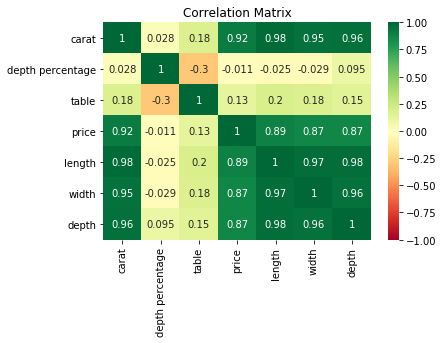

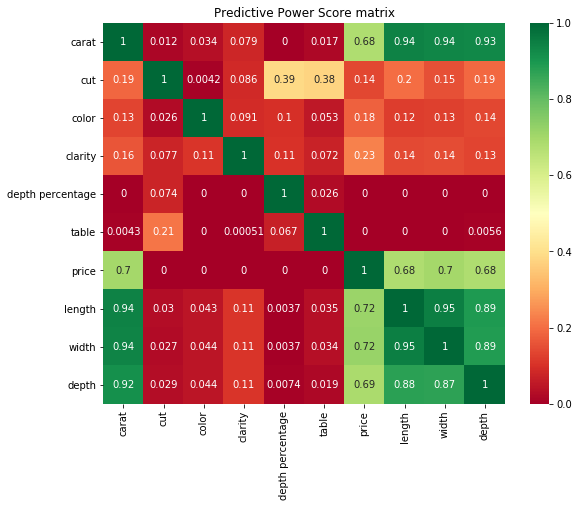

In [97]:
import seaborn as sns
import ppscore as pps

#basic descriptive stats

#shape of the dataset - (rows, columns)
print('Shape of dataset (rows/columns)\n', df.shape, sep="", end='\n' * 2)

#shows the amount of missing values per column
print('Number of missing values\n', df.isnull().sum(), sep="", end='\n' * 2)

print(df.describe(), end='\n' * 2)

#creates a heatmap with the correlations matrix of the numerical features
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#creates a heatmap with the predictive power score matrix of all features
fig, ax = plt.subplots(figsize=(9,7)) 
sns.heatmap(pps.matrix(df), annot=True, cmap='RdYlGn', vmin=0, vmax=1, ax=ax)
plt.title('Predictive Power Score matrix')
plt.show()

In [2]:
def distribution_graph(data, bins, xlabel):
    '''plots the distribution of data for a given vector
    
    input:  data: the vector (column of a df) to be plotted
            bins: the amount of bins (bars) over which the data will be distributed
            xlabel: the string label for the x-axis
    output: plot of the distribution for the given vector/column'''

    plt.hist(df[data], bins=bins, color = "black")
    plt.xlabel(xlabel)
    plt.ylabel('Number of observations')
    plt.show()

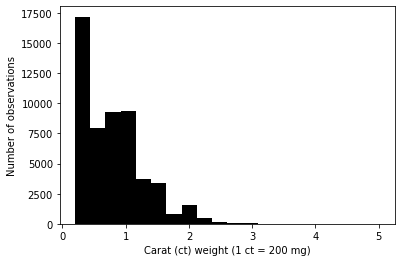

In [28]:
distribution_graph('carat', 20, 'Carat (ct) weight (1 ct = 200 mg)')

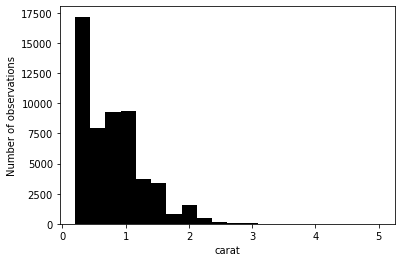

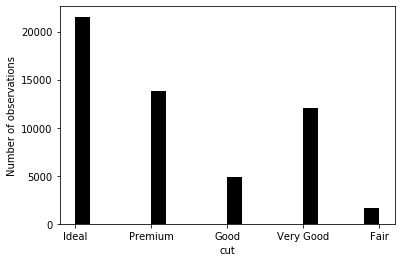

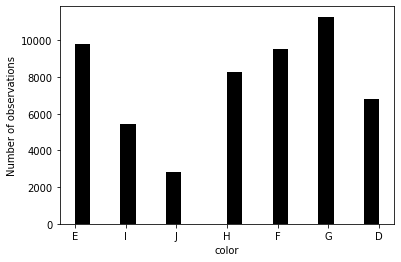

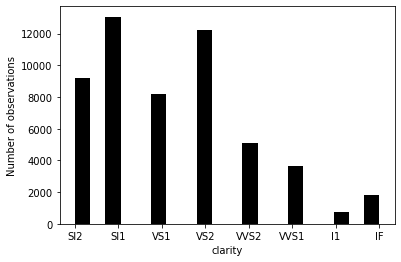

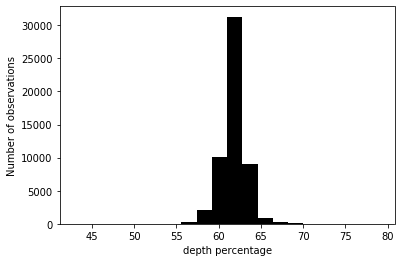

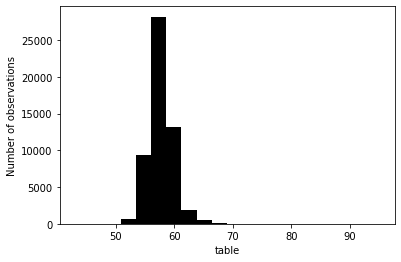

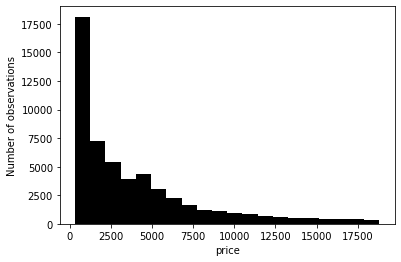

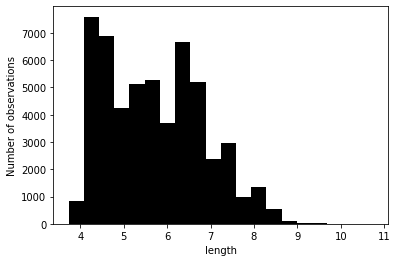

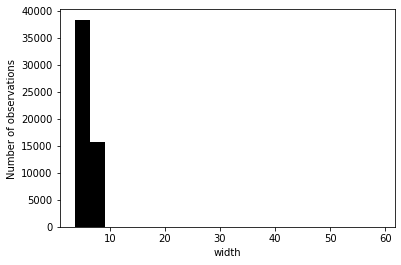

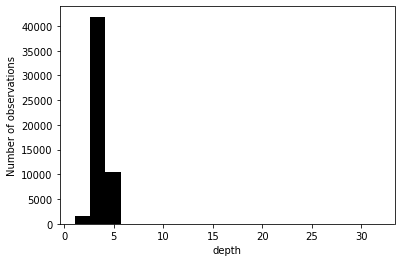

In [100]:
column_list = df.columns
for f in column_list:
    distribution_graph(f, 20, f)

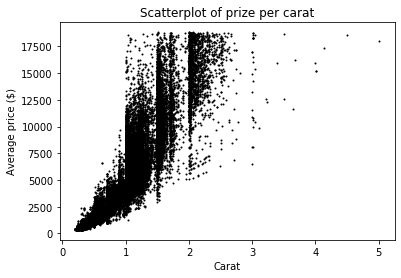

In [96]:
#plots a scatter plot with carats on the X-axis and price on the Y-axis

plt.scatter(df['carat'], df['price'], color='black', s=1)
plt.xlabel("Carat")
plt.ylabel('Average price ($)')
plt.title('Scatter plot of diamond prizes and carats')
plt.show()

In [3]:
#create the matrix X with the model features and y vector with the dependant variable 'price'
X = df.drop('price', axis=1)
y = df['price']

#normalize numerical features (x - mean) / st dev
num_cols = X.select_dtypes(['number']).columns
num_col_mean = {}
num_col_stdev = {}

for col in num_cols:
    num_col_mean[col] = X[col].mean()
    num_col_stdev[col] = st.stdev(X[col])
    X[col] = (X[col] - num_col_mean[col]) / num_col_stdev[col]

#create dummy variables for categorical features
cat_cols = X.select_dtypes(['object']).columns

for col in cat_cols:
    X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep="_")], axis = 1)

X.head()

,carat,depth percentage,table,length,width,depth,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.198193,-0.174201,-1.099715,-1.591558,-1.539205,-1.580069,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,-1.240405,-1.361078,1.585973,-1.645157,-1.661998,-1.750880,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,-1.198193,-3.385749,3.376432,-1.502227,-1.460266,-1.750880,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-1.071556,0.454145,0.243129,-1.368229,-1.319931,-1.295384,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,-1.029344,1.082491,0.243129,-1.243165,-1.214679,-1.124573,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [11]:
'''
Set a baseline prediction based on the median price of a diamond in the training data set.
A negative R2-score means the prediction is worse than a prediction using the mean. However
the absolute mean error is lower when using the median rather than the mean (MAE: 3036 dollar).
'''

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#create train and test sets of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state=38)

#makes the baseline prediction 
baseline_pred = y_train.median()
baseline_error = np.mean(abs(baseline_pred - y_test))

baseline_pred = [baseline_pred] * len(y_test)
print("Mean absolute error:", int(baseline_error), "dollar")
print("R2 score:", round(r2_score(y_test, baseline_pred),3))


Mean absolute error: 2810 dollar
R2 score: -0.147


In [5]:
#Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#instantiate linear model
lm = LinearRegression()

#fit the model to the training set
lm.fit(X_train, y_train)

#predict using the test set and training set
pred_test = lm.predict(X_test)
pred_train = lm.predict(X_train)

#score the two predictions above
score_test = r2_score(y_test, pred_test)
score_train = r2_score(y_train, pred_train)

#create a new table with coefficiencts found by the model
coefs = pd.DataFrame()
coefs['feature'] = X.columns
coefs['coefficient'] = lm.coef_
coefs['absolute coef'] = np.abs(lm.coef_)

#sort the coefficients from large to small and add an extra row with the intercept at 
#the bottom of the table
coefs = coefs.sort_values('coefficient', ascending=False)
coefs = coefs.append({'feature':'Intercept', 'coefficient':lm.intercept_, \
                      'absolute coef':np.abs(lm.intercept_)}, ignore_index=True)

coefs

,feature,coefficient,absolute coef
0,carat,5438.782216,5438.782216
1,clarity_IF,1543.704421,1543.704421
2,clarity_VVS2,1185.515985,1185.515985
3,clarity_VVS1,1149.641882,1149.641882
4,color_D,831.329854,831.329854
5,clarity_VS1,790.834723,790.834723
6,color_E,621.444975,621.444975
7,color_F,562.540793,562.540793
8,clarity_VS2,456.618591,456.618591
9,color_G,352.642562,352.642562


In [6]:
lm_error = np.mean(abs(pred_test - y_test))

print("Average error:", int(lm_error), "dollar")
print("R2-score of the model on the test data:", round(score_test,3))

Average error: 739 dollar
R2-score of the model on the test data: 0.92


In [7]:
#Random Forest Regression Model

from sklearn.ensemble import RandomForestRegressor

#instantiate the Random Forest regressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

#fit the model to the training set
rf.fit(X_train, y_train)

#predict using the test set
rf_preds = rf.predict(X_test)

#score the prediction
rf_r2_score= r2_score(y_test, rf_preds)

#calculate average error between prediction and known y-value
rf_error = np.mean(abs(rf_preds - y_test))

#print results
print("Average error:", int(rf_error), "dollar")
print("R2-score of the model on the test data:", round(rf_r2_score,3))

Average error: 294 dollar
R2-score of the model on the test data: 0.978


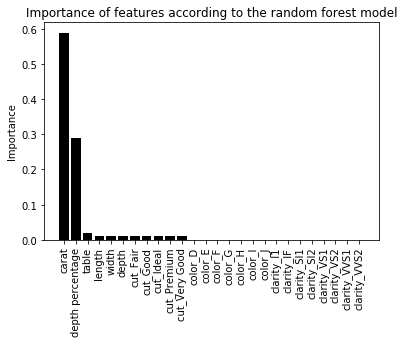

In [14]:
#gets the importance of features according to the random forest regression and shows them in a bar chart

importance = list(rf.feature_importances_.round(2))
importance.sort(reverse=True)
features = list(X.columns)

x_values = np.array(list(range(len(importance))))
plt.bar(features, importance, color='black')
plt.xticks(rotation='vertical')
plt.ylabel('Importance')
plt.title('Importance of features according to the random forest model')
plt.show()


In [13]:
def row_prediction_compare(row_num, print_result=True):
    '''
    This function outputs predictions based on a given row of the test set using the Linear model (LM)
    and the Random Forest Model (RF). Also gives the true value from the test set to compare.
    
    
    Input:
        row_num: row number of the test set
        print_result: True if you want to print the results or False if you just want the function
        to return a list with the predictions
    Output:
        print or list with LM prediction, RF prediction and the true value
    '''
    lm_row_prd = lm.predict(np.array(X_test.iloc[row_num]).reshape(1,-1))
    rf_row_prd = rf.predict(np.array(X_test.iloc[row_num]).reshape(1,-1))
    true_value = y_test.iloc[row_num]

    if print_result == True:
        print("Linear model prediction:", int(lm_row_prd), "dollar. \nRandom forest prediction:", \
              int(rf_row_prd), "dollar.")
        print("True value:", int(true_value))
    else:          
        result = [int(lm_row_prd[0]), int(rf_row_prd[0]), true_value]
        return result

In [14]:
predictions_table = pd.DataFrame(columns = ['LM pred', 'RF pred', 'True value'])
for i in range(10):
    predictions_table.loc[i] = row_prediction_compare(i, print_result=False)

predictions_table

,LM pred,RF pred,True value
0,4372,4339,3888
1,1438,1355,1343
2,1675,2367,2289
3,1888,1088,1289
4,2017,1683,1949
5,15156,14948,14666
6,4209,4054,4120
7,159,590,557
8,5184,4801,4580
9,5760,5199,4989


In [15]:
row_prediction_compare(5)

Linear model prediction: 15156 dollar. 
Random forest prediction: 14948 dollar.
True value: 14666


In [88]:
'''
this section creates an image of one of the trees of a random forest regression.

keep the max_depth option in the instantiation of the RF-model low unless you 
want to wait forever for an uninterpretable image
'''

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

#instantiate the Random Forest regressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth=5)

#fit the model to the training set
rf.fit(X_train, y_train)

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = X.columns, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')